In [7]:
import Particle
import Parabolas
import numpy as np
import importlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams['figure.dpi']= 300

The purpose of this tool is to calculate the orbit of different particles in a toroidal magnetic field $\vec B$ with large aspect ratio (LAR). The orbits are calculated by solving Hamiltons equations as presented in "The theory of toroidally confined plasmas" by R. B. White,with a 4th order Runge-Kutta method

Our dynamical variables are  $\theta, P_\theta, \zeta, P_\zeta$ and $ \rho_{||}$, and they are governed through Hamilton's equations:

$$
\dot \theta = \dfrac{1}{q}\rho_{||}B^2 + \dfrac{1}{\sqrt{2\psi}}(\mu + \rho_{||}^2B)
$$ \ 
$$
\dot P_\theta = -\dfrac{1}{q}(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta)
$$\
$$
\dot \zeta = \rho_{||}B^2
$$\
$$
\dot \rho_{||} = -\dfrac{1}{q}(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta)
$$\
where:  $\quad B = 1 - \sqrt{2\psi}\cos(\theta), \qquad q=1$

### Part 1: Particle Initialization and obrit calculation

In this cell we can create multiple particles independently. By setting cwp (current working particle), we chose the particle to proceed. That way we can keep all previous particles in memory and switch cwp at any point.

In [8]:
importlib.reload(Particle) # for debugging, can be removed
importlib.reload(Parabolas) # for debugging, can be removed

# Set up Magnetic Field B
i, g, delta = 0, 1, 0 
psi_wall = .03 # Better be < .5

# Create Particle
species = "e"
# Initial Conditions
mu = 10**(-3) # Magnetic moment
theta0 = 0 
psip0 = .058
z0 = 0
Pz0 = -0.02
rho0 = Pz0 + psip0
tspan = np.linspace(0, 5000, 1000)
init_cond = np.array([theta0, psip0, z0, Pz0, rho0])

#Particle Creation
Electron1 = Particle.Particle(species, init_cond, mu, tspan, psi_wall=psi_wall)
cwp = Electron1
cwp.orbit()
print(cwp)

Particle of Species:	 "e"
Calculated orbit:	 True

Constants of motion:
Particle Energy:	E = 0.00097336
Toroidal Momenta:	Pζ = -0.02

Orbit Type: Trapped - Lost



### Part 2: Plots

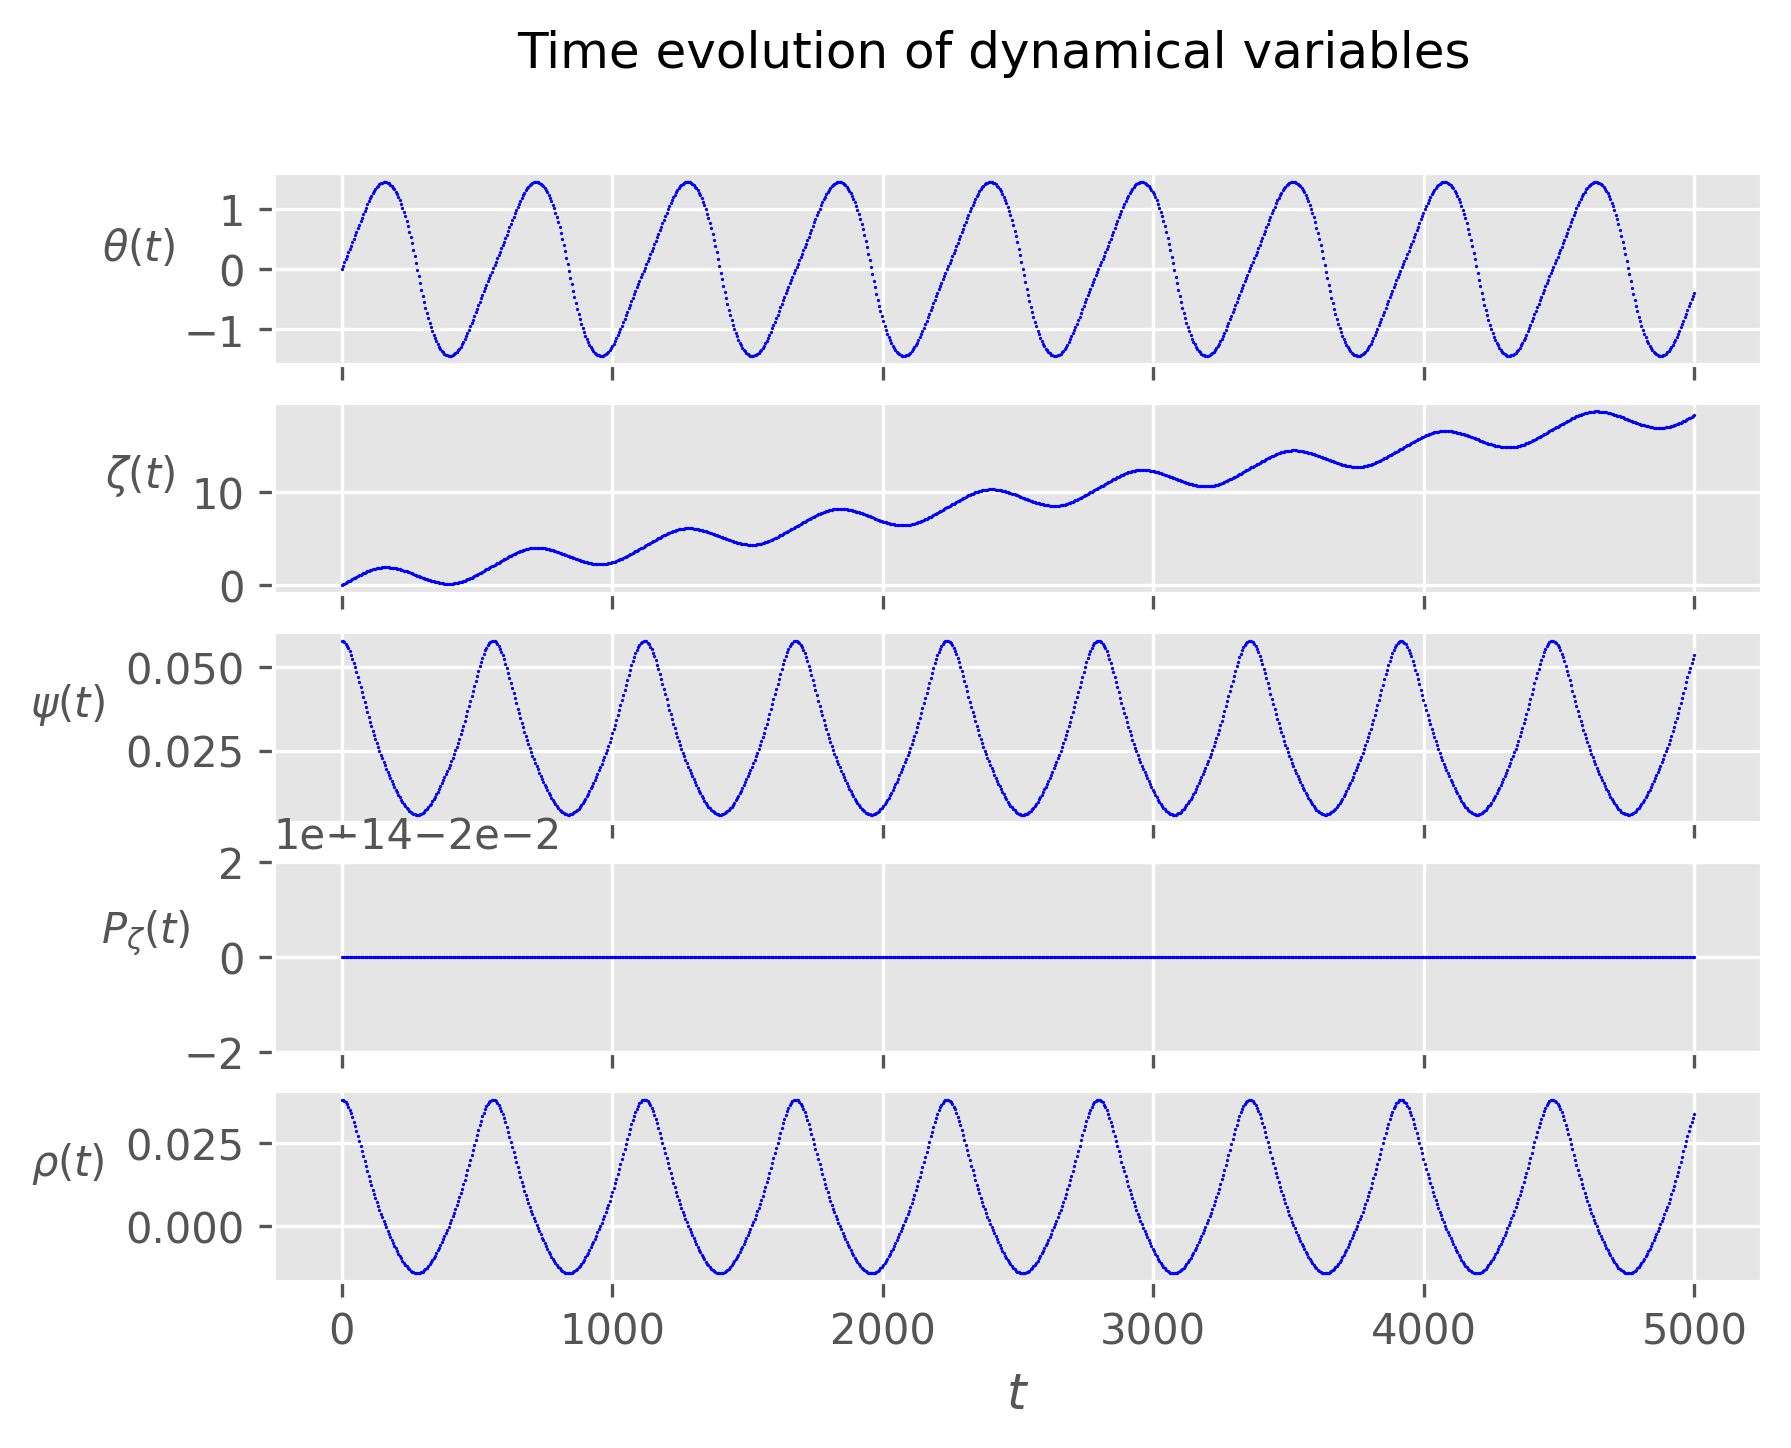

In [9]:
cwp.plot_time_evolution()

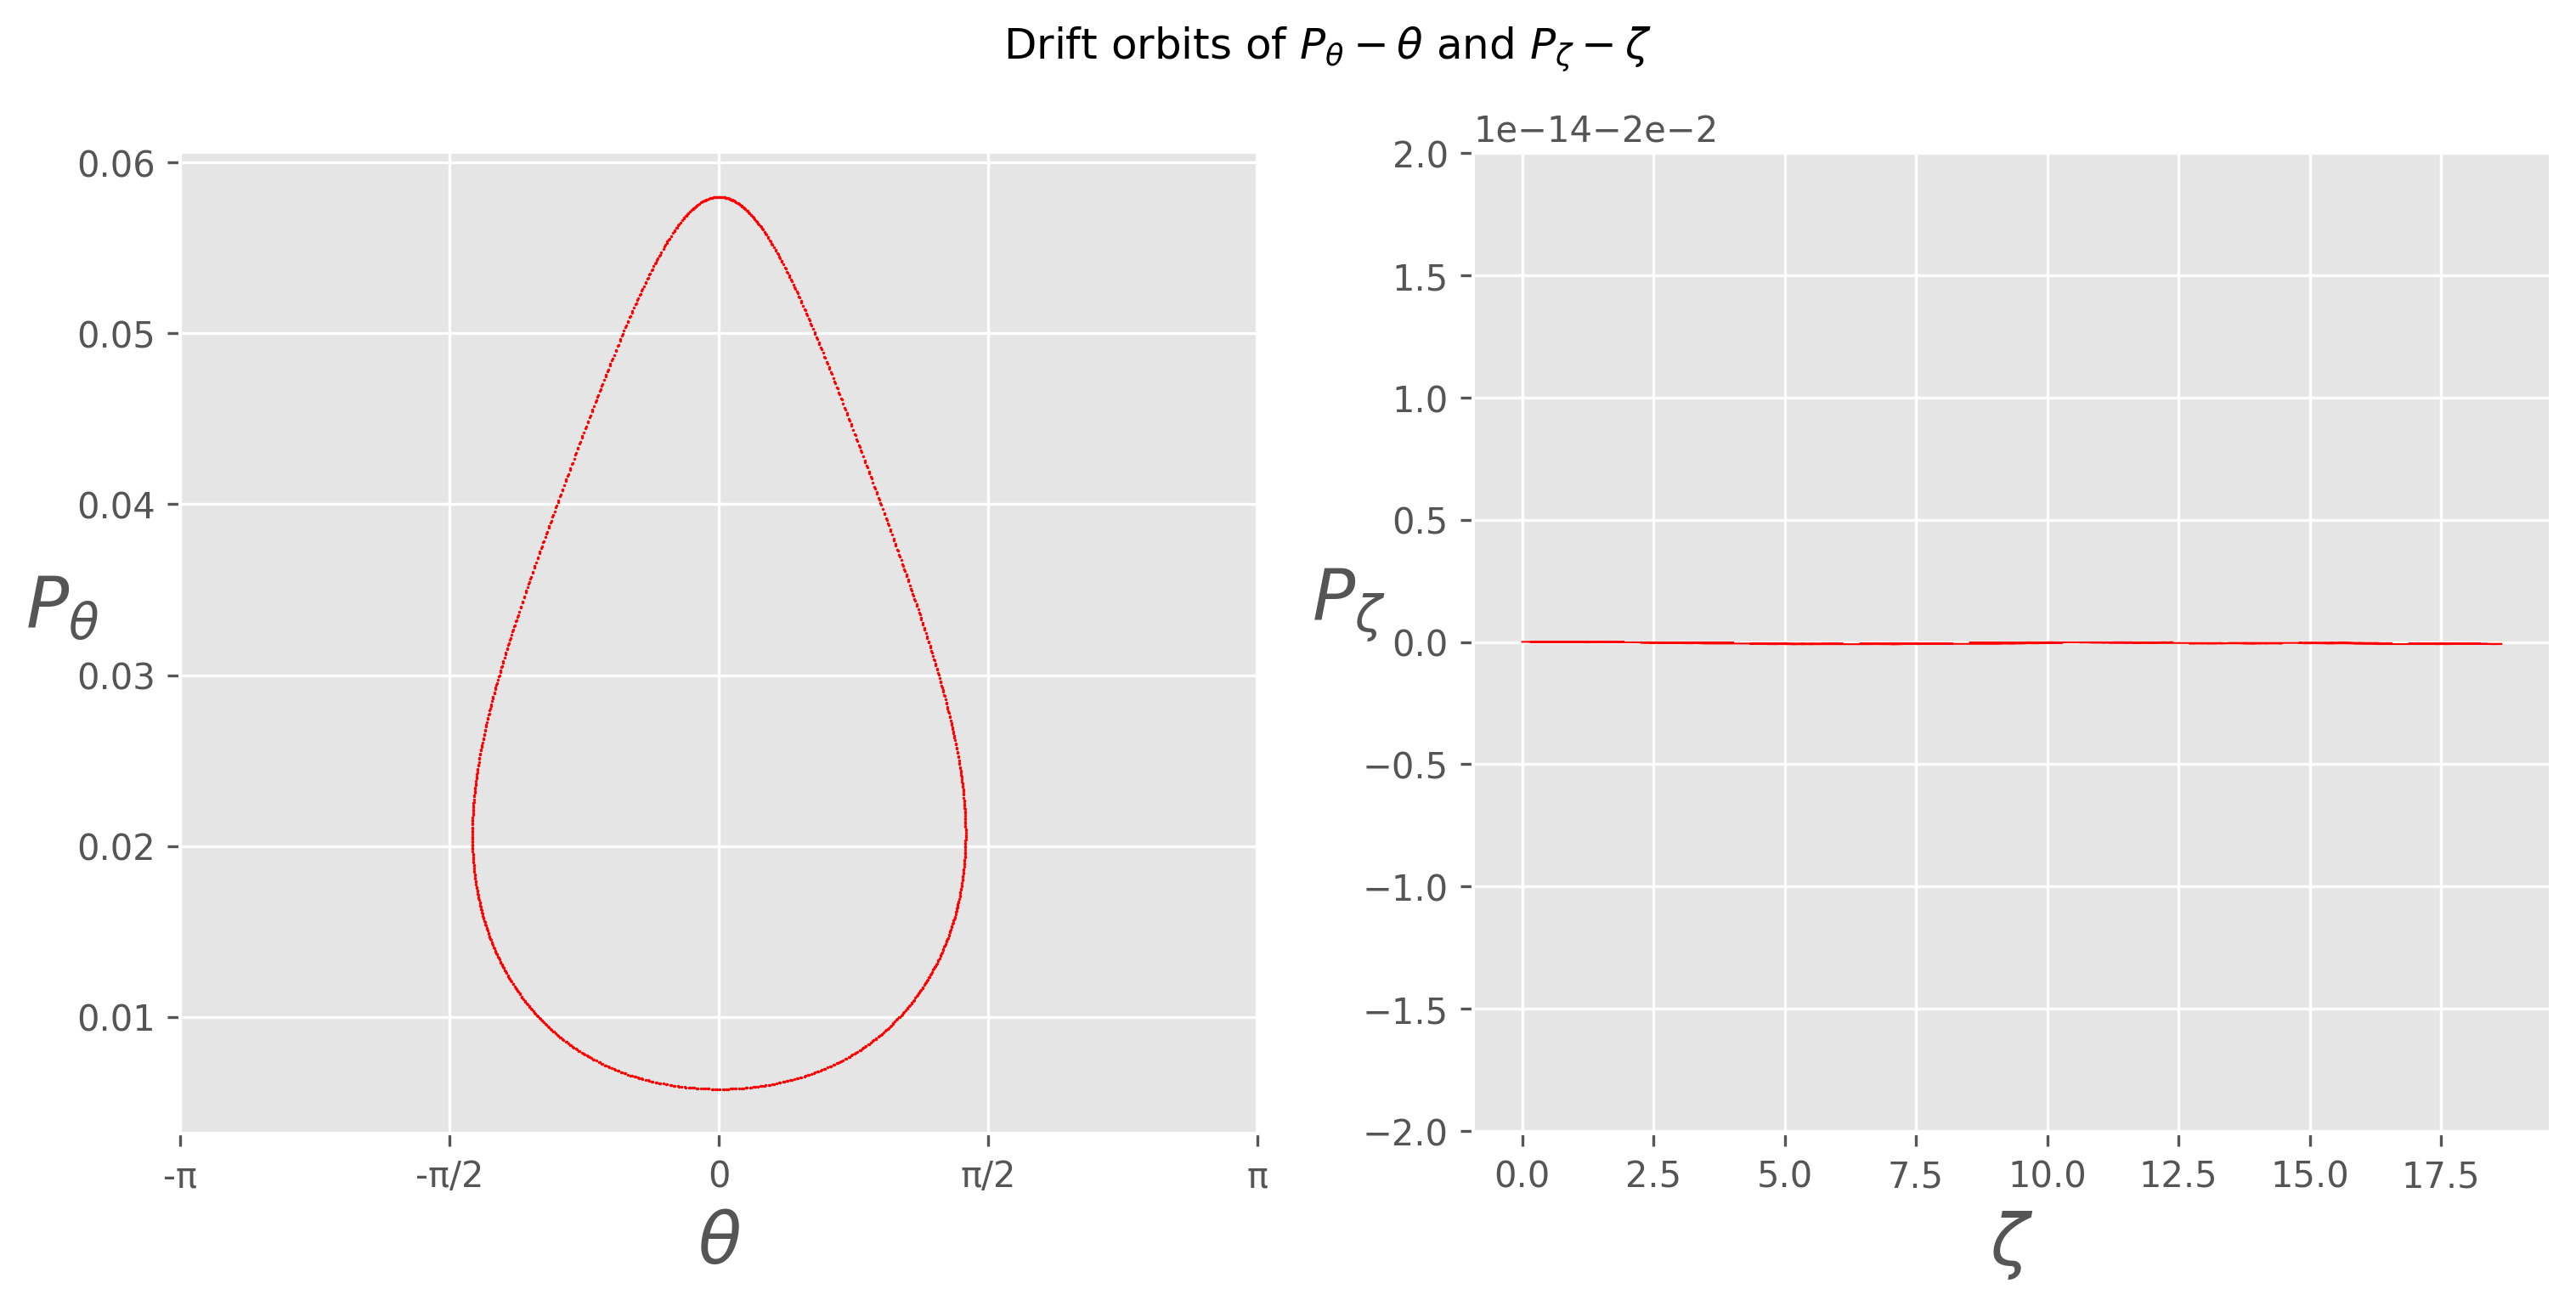

In [10]:
cwp.plot_drift(theta_lim = [-np.pi ,np.pi])

### Energy Contour Plots

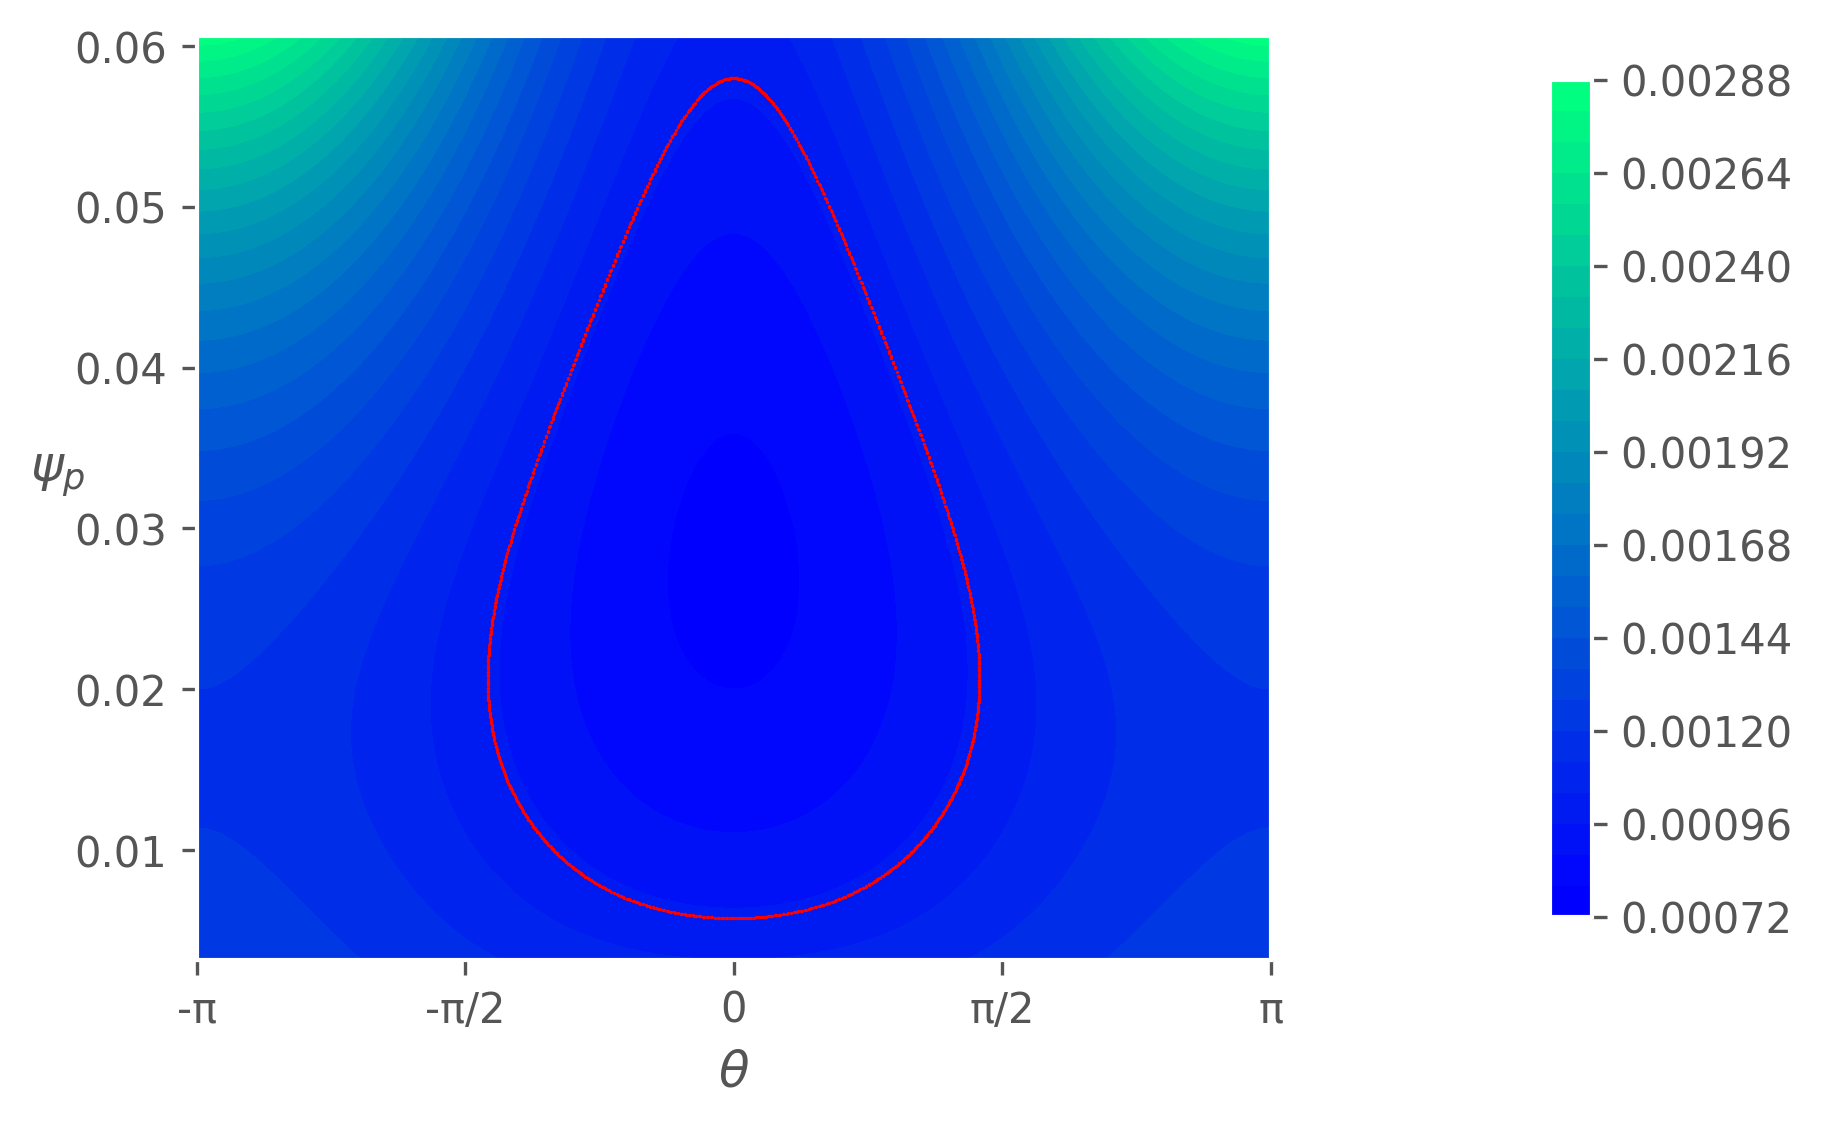

In [11]:
cwp.contour_energy(theta_lim = "auto", psi_lim = "auto", Pz = Pz0)

### Orbit types parabolas

The top left parabola is defined in White as:
$$
\dfrac{(P_\zeta + \psi_{wall})^2B^2_{max}}{2g^2(\psi_{wall})}+\mu B_{max}-E=0
$$
We can re-order the terms as such:
$$
\bigg(\dfrac{\mu B_0}{E} \bigg) = - \dfrac{B_{max}B_0\psi^2_{wall}}{2g^2E}
\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)^2 - 
\dfrac{B_{max}B_0\psi^2_{wall}}{g^2E}\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)-
\dfrac{B_{max}B_0\psi^2_{wall}}{2g^2E} + \dfrac{B_0}{B_{max}}
$$
By defining the new variables:
$$
x=\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)\quad,\quad y = \bigg(\dfrac{\mu B_0}{E} \bigg)
$$
we define a parabola $y = \alpha x^2 + \beta x + \gamma$. Now we can easily find the minima/maxima and axis intercepts.\
Note: Since $B = 1 - \sqrt{2\psi}\cos\theta \quad$,   $\psi_{wall}$ should be less that 0.5

As for figuring out if the particle is Lost or Confined, we need only to check if its orbit point lies in-between the 2 left parabolas.

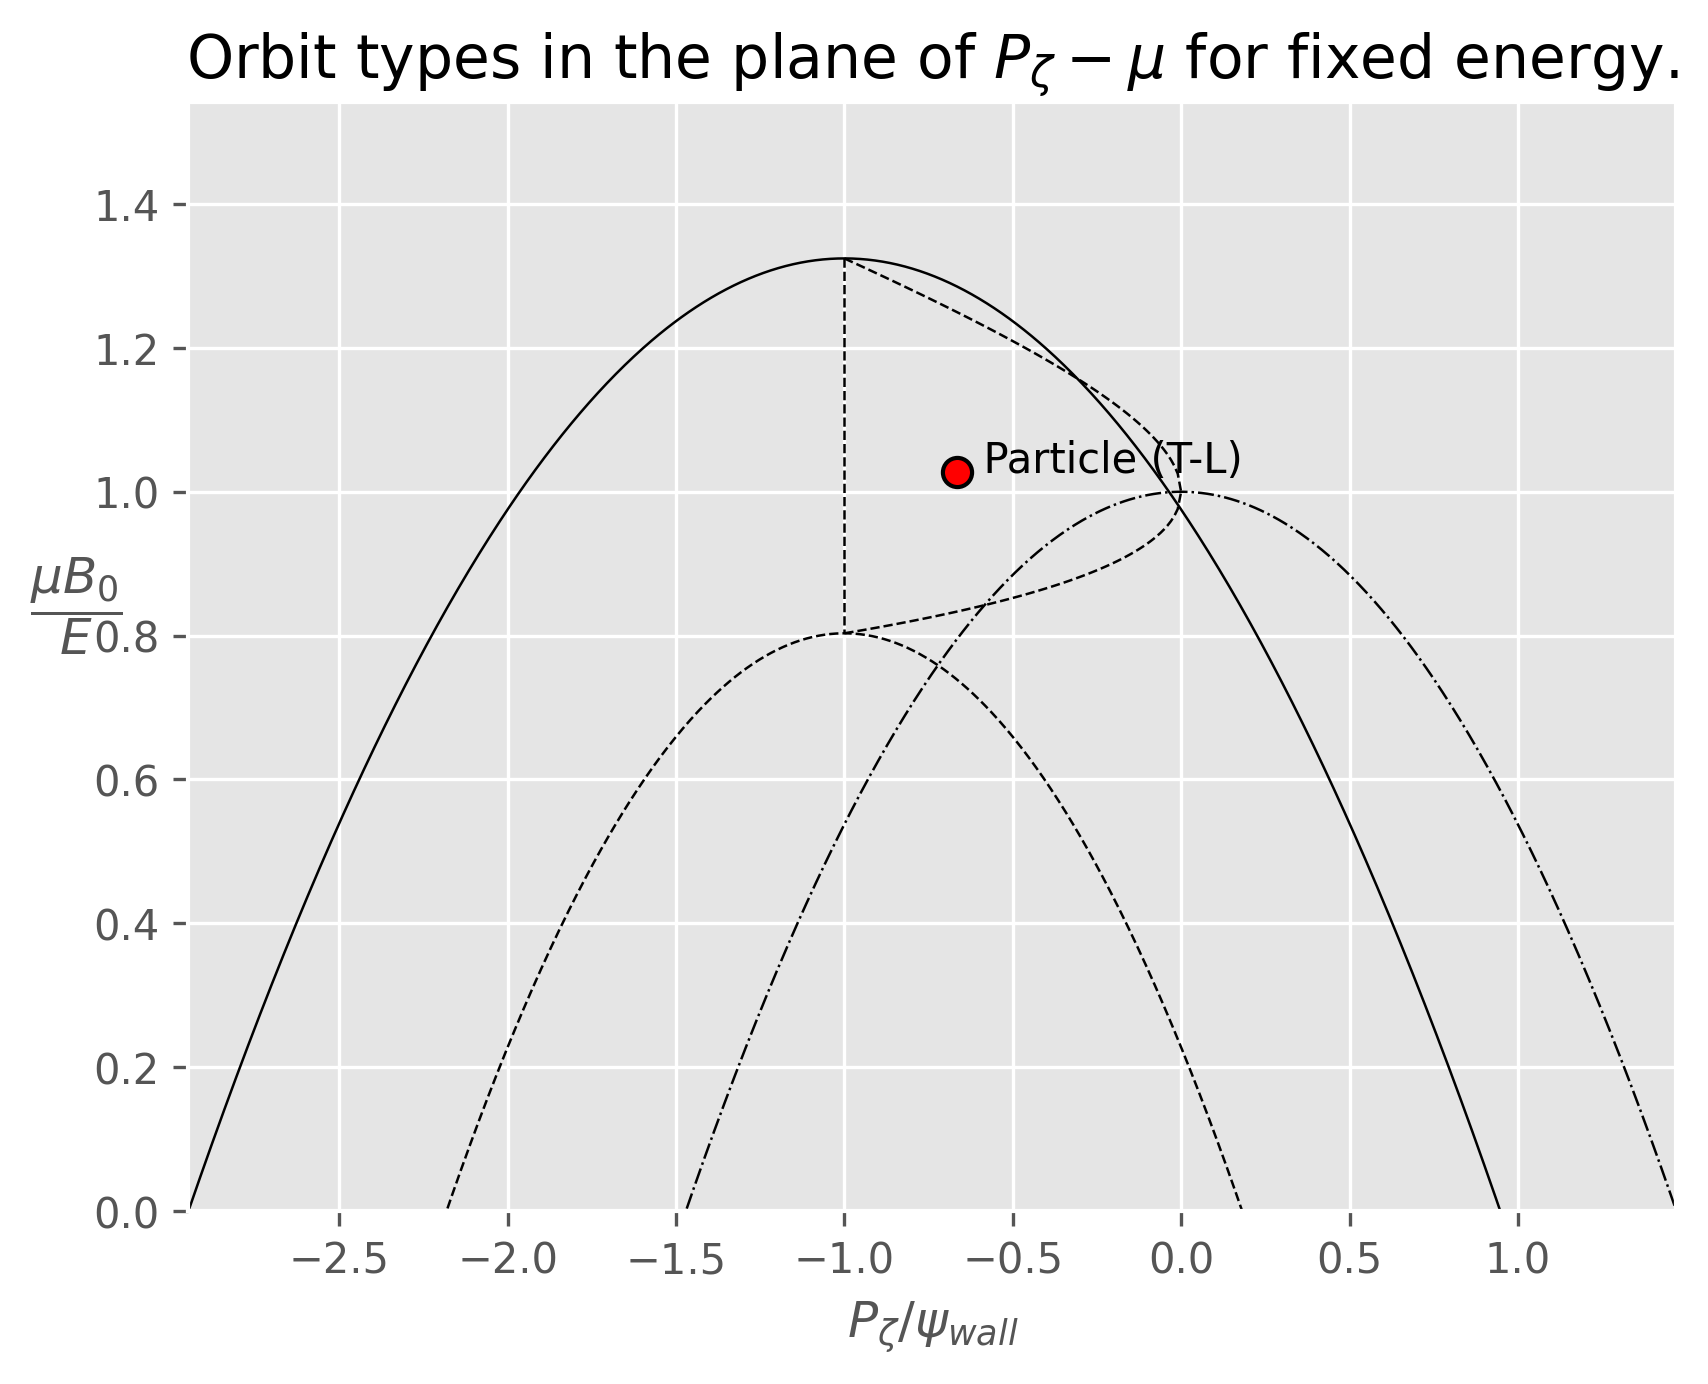

In [12]:
importlib.reload(Parabolas) # for debugging, can be removed
Parabolas_plot = Parabolas.Orbit_parabolas(cwp.E, psi_wall=psi_wall)
Parabolas_plot.plot()
Parabolas_plot.plot_vertical()
Parabolas_plot.plot_tp_boundary()
cwp.plot_orbit_type_point()